In [ ]:
pip install opencv-python

# Face Recognition Model 2

In [30]:
import tensorflow as tf
import numpy as np
import pandas as pd
import random
from sklearn.metrics import accuracy_score, confusion_matrix

import cv2 as cv
from skimage import io

from tensorflow import keras
from keras import layers
from keras import Model
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.applications.inception_v3 import InceptionV3
import keras
from keras.layers import Dense,Input,Dropout,GlobalAveragePooling2D,Flatten,Conv2D,BatchNormalization,Activation,MaxPooling2D
from keras.models import Model,Sequential, load_model
from keras.optimizers import Adam,SGD,RMSprop

In [2]:
import os
current_directory = os.getcwd()
print("Current Directory:", current_directory)


Current Directory: c:\Users\makpe\OneDrive\Documents\Data Scientist\Deep Learning\Final_Project_DL_Oct_23


### Confirming addresses of Training and Test Datasets

In [ ]:
for dirname, _, filenames in os.walk(current_directory + '/face_recognition_dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

### Estabishing paths to Datasets

In [27]:
testing_path= current_directory + '/face_recognition_dataset/Testing/Testing'
training_path= current_directory + '/face_recognition_dataset/Training/Training'

class_names = os.listdir(training_path)
print(class_names)

img=cv.imread(training_path + '/Angry/Angry-1.jpg')
# print(img)
img.shape
print(testing_path)

['Angry', 'Fear', 'Happy', 'Neutral', 'Sad', 'Suprise']
c:\Users\makpe\OneDrive\Documents\Data Scientist\Deep Learning\Final_Project_DL_Oct_23/face_recognition_dataset/Testing/Testing


## Image Preprocessing

In [57]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(training_path,
                                                    batch_size = 128,
                                                    class_mode = 'categorical', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( testing_path,
                                                          batch_size  = 128,
                                                          class_mode  = 'categorical', 
                                                          target_size = (150, 150))



Found 28273 images belonging to 6 classes.
Found 7067 images belonging to 6 classes.


## EDA - Emotion Examples Count

In [7]:
import glob

angry=[f for f in glob.glob(training_path+'/Angry' + "/*", recursive=True)]
fear=[f for f in glob.glob(training_path+'/Fear' + "/*", recursive=True)]
happy=[f for f in glob.glob(training_path+'/Happy' + "/*", recursive=True)]
neutral=[f for f in glob.glob(training_path+'/Neutral' + "/*", recursive=True)]
sad=[f for f in glob.glob(training_path+'/Sad' + "/*", recursive=True)]
surprise=[f for f in glob.glob(training_path+'/Suprise' + "/*", recursive=True)]

print(len(angry))
print(len(fear))
print(len(happy))
print(len(neutral))
print(len(sad))
print(len(surprise))

3995
4097
7215
4965
4830
3171


## Build the Model

In [58]:
# build the model

model = Sequential()

no_of_classes = 6

model.add(Conv2D(32, (3, 3), padding='same', input_shape=(150, 150, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (5, 5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dense(no_of_classes, activation='softmax'))

model.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 48, 48, 32)        320       
                                                                 
 batch_normalization_24 (Ba  (None, 48, 48, 32)        128       
 tchNormalization)                                               
                                                                 
 activation_24 (Activation)  (None, 48, 48, 32)        0         
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 24, 24, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_20 (Dropout)        (None, 24, 24, 32)        0         
                                                                 
 conv2d_17 (Conv2D)          (None, 24, 24, 64)       

## Set the Callbacks

In [56]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("./model.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
    checkpoint
]

## Fit the Model

In [ ]:
batch_size = 64
epochs = 100

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=220,
    epochs=epochs,
    callbacks=callbacks
    )

## Plot Model Accuracy and Loss on Training and Validation Datasets

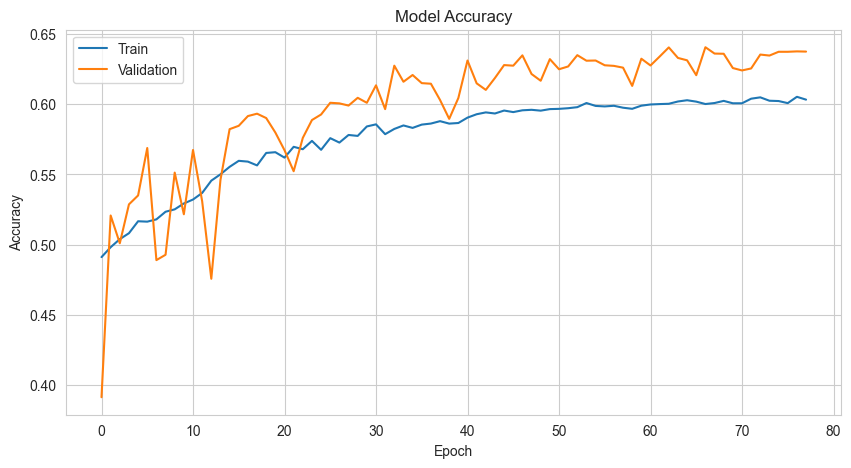

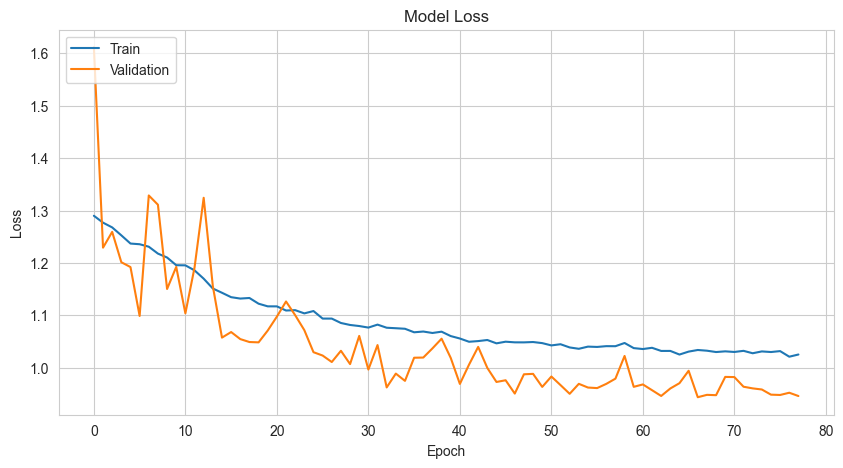

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
sns.set_style("whitegrid")
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
sns.set_style("whitegrid")
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Create X_test, y_test sets from Validation Data

In [44]:
X_test, y_test = [], []

for _ in range(len(validation_generator)):
    batch_data, batch_labels = validation_generator.next()
    X_test.append(batch_data)
    y_test.append(batch_labels)

# Concatenate the batches to form the complete test dataset
X_test = np.concatenate(X_test)
y_test = np.concatenate(y_test)


In [45]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predicted probabilities to class labels

221/221 [==============================] - 39s 175ms/step


## Confusion Matrix

In [46]:
def plot_confusion_matrix(confusion_mtx, classes):
    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

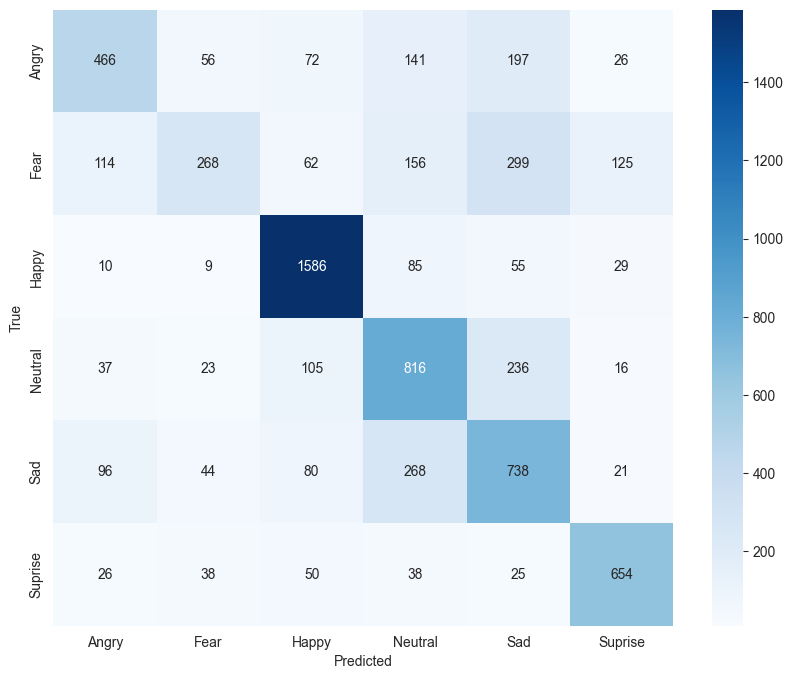

In [48]:
confusion_mtx = confusion_matrix(np.argmax(y_test, axis=1), y_pred_classes)
plot_confusion_matrix(confusion_mtx, class_names)